In [46]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score


## Chargement des données

In [31]:
df = pd.read_csv("dataset-68eb8f248e099277381881.csv")



In [32]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [34]:
df.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


In [35]:
# df["Courier_Experience_yrs"].fillna(df["Courier_Experience_yrs"].mean(), inplace=True)
# for col in ["Weather", "Traffic_Level", "Time_of_Day"]:
#     df[col].fillna(df[col].mode()[0], inplace=True)
# Fill numeric column with mean
df["Courier_Experience_yrs"] = df["Courier_Experience_yrs"].fillna(df["Courier_Experience_yrs"].mean())

# Fill categorical columns with mode
for col in ["Weather", "Traffic_Level", "Time_of_Day"]:
    df[col] = df[col].fillna(df[col].mode()[0])


In [36]:
def check_columns_info(df):
    info = pd.DataFrame({
        "Type": df.dtypes,
        "Missing": df.isnull().sum()
    })
    return info
check_columns_info(df)

,Type,Missing
Order_ID,int64,0
Distance_km,float64,0
Weather,object,0
Traffic_Level,object,0
Time_of_Day,object,0
Vehicle_Type,object,0
Preparation_Time_min,int64,0
Courier_Experience_yrs,float64,0
Delivery_Time_min,int64,0


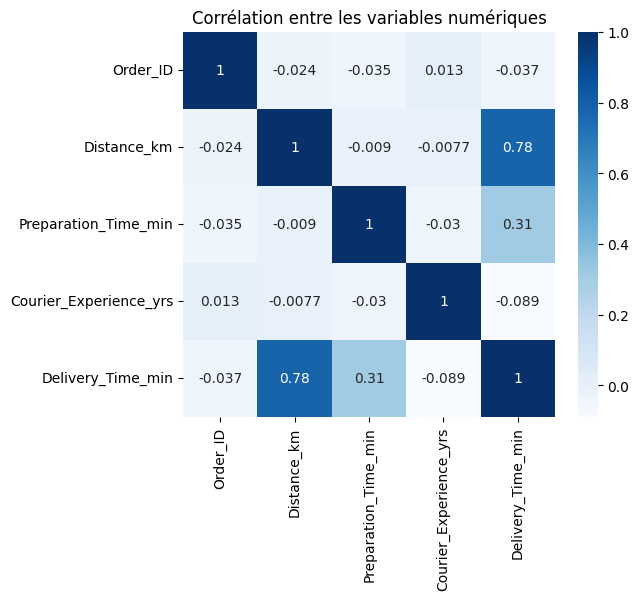

In [37]:
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="Blues")
plt.title("Corrélation entre les variables numériques")
plt.show()

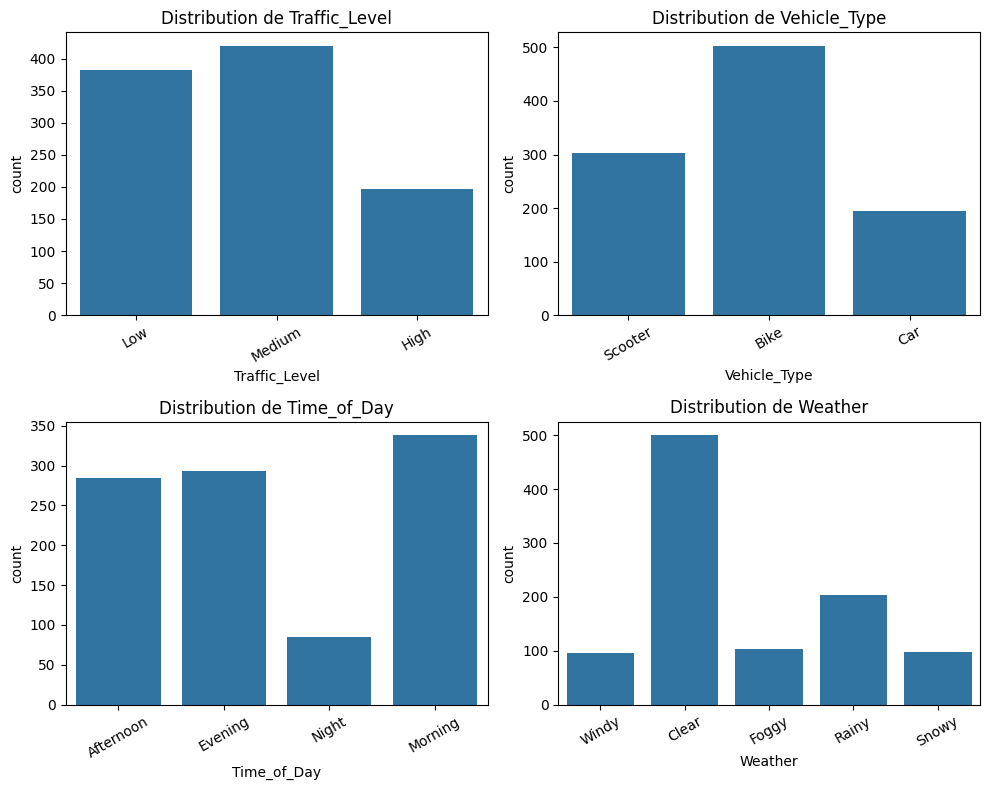

In [38]:
cat_vars = ["Traffic_Level", "Vehicle_Type", "Time_of_Day", "Weather"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, col in enumerate(cat_vars):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"Distribution de {col}")
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

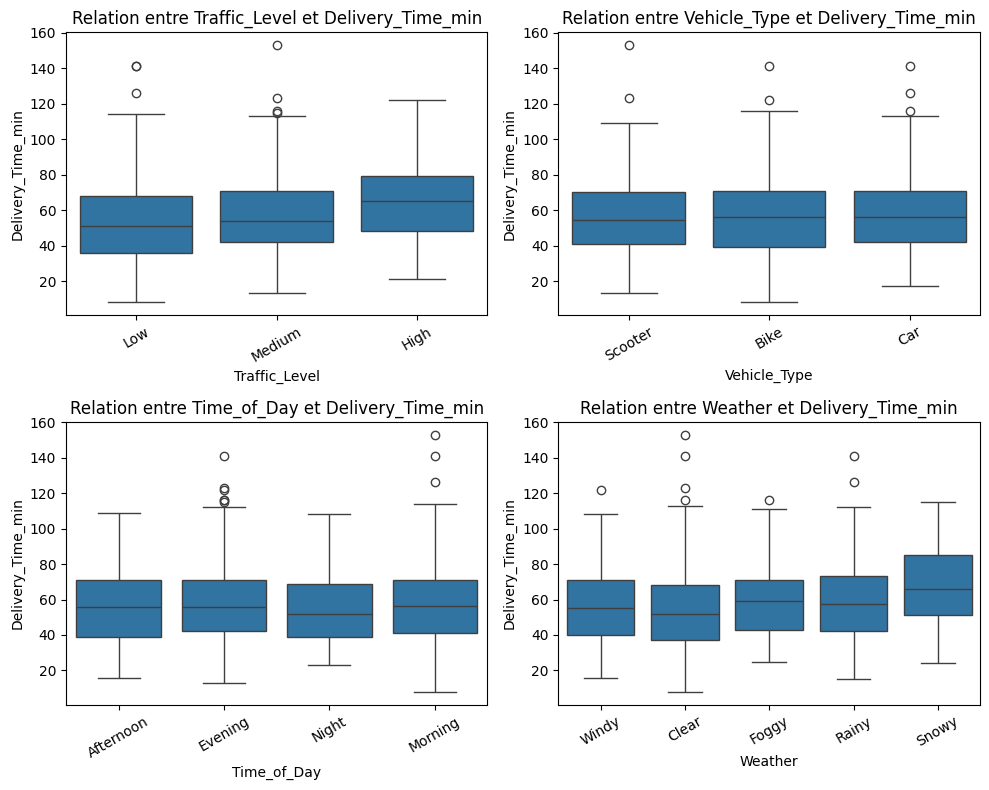

In [39]:
cat_vars = ["Traffic_Level", "Vehicle_Type", "Time_of_Day", "Weather"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
for i, col in enumerate(cat_vars):
    sns.boxplot(data=df, x=col, y="Delivery_Time_min", ax=axes[i])
    axes[i].set_title(f"Relation entre {col} et Delivery_Time_min")
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

In [ ]:
# 1. Définir X et y + Split
from sklearn.base import r2_score
from sklearn.metrics import mean_absolute_error


target_col = "Delivery_Time_min"   
X = df[selected_features]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

# 2. RandomForestRegressor + GridSearch 
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('model', RandomForestRegressor(random_state=42))
])

rf_param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
}

rf_grid = GridSearchCV(
    rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)

print("\n=== Random Forest Best Params ===")
print(rf_grid.best_params_)

rf_best_model = rf_grid.best_estimator_
rf_pred = rf_best_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest R²: {rf_r2:.3f}")


# === 3. SVR + GridSearch ===
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # SVR a besoin de scaling
    ('model', SVR())
])

svr_param_grid = {
    'model__kernel': ['rbf', 'linear'],
    'model__C': [0.1, 1, 10],
    'model__epsilon': [0.1, 0.5, 1]
}

svr_grid = GridSearchCV(
    svr_pipeline,
    param_grid=svr_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
svr_grid.fit(X_train, y_train)

print("\n=== SVR Best Params ===")
print(svr_grid.best_params_)

svr_best_model = svr_grid.best_estimator_
svr_pred = svr_best_model.predict(X_test)

svr_mae = mean_absolute_error(y_test, svr_pred)
svr_r2 = r2_score(y_test, svr_pred)

print(f"SVR MAE: {svr_mae:.2f}")
print(f"SVR R²: {svr_r2:.3f}")


# === 4. Choix du meilleur modèle ===
if rf_mae < svr_mae:
    print("\n Le meilleur modèle est: RandomForestRegressor")
    best_model = rf_best_model
    best_mae = rf_mae
    best_r2 = rf_r2
else:
    print("\n Le meilleur modèle est: SVR")
    best_model = svr_best_model
    best_mae = svr_mae
    best_r2 = svr_r2

print(f"\nMeilleur MAE: {best_mae:.2f}")
print(f"Meilleur R²: {best_r2:.3f}")
# # ==============================
# # 3. Encode categorical columns
# # ==============================
# categorical_cols = df.select_dtypes(include='object').columns

# for col in categorical_cols:
#     encoder = OneHotEncoder(drop='first', sparse_output=False)
#     encoded = encoder.fit_transform(df[[col]])
#     encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]))
#     df = pd.concat([df.drop(columns=[col]), encoded_df], axis=1)

# # ==============================
# # 4. Scale numeric columns
# # ==============================
# scaler = StandardScaler()
# num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop("Delivery_Time_min")
# df[num_cols] = scaler.fit_transform(df[num_cols])

# # ==============================
# # 5. Define features and target
# # ==============================
# X = df.drop(columns=["Delivery_Time_min", "Courier_Experience_yrs", "Order_ID"])
# y = df["Delivery_Time_min"]

# # ==============================
# # 6. Feature selection
# # ==============================
# selector = SelectKBest(score_func=f_regression, k=5)
# X_selected = selector.fit_transform(X, y)
# selected_features = X.columns[selector.get_support()]
# print("Selected features:", selected_features.tolist())


# # ==============================
# # 7. Train/test split
# # ==============================
# X_train, X_test, y_train, y_test = train_test_split(
#     X[selected_features], y, test_size=0.2, random_state=42)

# # ==============================
# # 8. Train Random Forest
# # ==============================
# model = RandomForestRegressor(
#     n_estimators=200,
#     random_state=42,
#     oob_score=True,
#     n_jobs=-1
# )
# model.fit(X_train, y_train)

# # ==============================
# # 9. Evaluate the model
# # ==============================
# train_r2 = model.score(X_train, y_train)
# test_r2 = model.score(X_test, y_test)

# print("\nModel Evaluation:")
# print(f"Train R² Score: {train_r2:.3f}")
# print(f"Test R² Score: {test_r2:.3f}")
# print(f"OOB Score: {model.oob_score_:.3f}")

# # ==============================
# # 10. Cross-validation
# # ==============================
# cv_scores = cross_val_score(model, X[selected_features], y, cv=5, scoring='r2')
# print(f"Cross-validated R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

ImportError: cannot import name 'r2_score' from 'sklearn.base' (c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py)

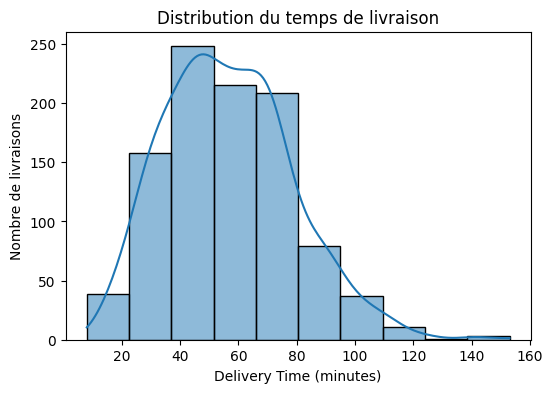

In [41]:
plt.figure(figsize=(6,4))
sns.histplot(df["Delivery_Time_min"], bins=10, kde=True)
plt.title("Distribution du temps de livraison")
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Nombre de livraisons")
plt.show()

In [42]:
def remove_outliers(df, columns):
    for col in columns:
        if df[col].dtype != 'object':  # seulement pour les colonnes numériques
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            low = Q1 - 1.5 * IQR
            high = Q3 + 1.5 * IQR
            df = df[(df[col] >= low) & (df[col] <= high)]
    return df

# Appliquer sur les colonnes K-best
df_clean = remove_outliers(df, selected_features)
print("Avant :", df.shape)
print("Après suppression des outliers :", df_clean.shape)
clean_file_path = "clean_data.csv"
df.to_csv(clean_file_path, index=False)
print(f"Cleaned data saved to '{clean_file_path}'")

Avant : (1000, 16)
Après suppression des outliers : (699, 16)
Cleaned data saved to 'clean_data.csv'
